# Cnn classifier

In this notebook, we implemented a Convolutional Neural Network (CNN) that processes images through convolutional and pooling layers. These layers reduce the original dimensionality of the data while increasing the number of features, thereby extracting meaningful patterns from the input. After this, the data is linearized, and the network is trained to hoppefuly produce a correct output.

### Imports

All the necesssary imports in this notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle



# Terms to know for Audio in Digital Form:

## Frequency (Hz)
- Frequency describes the differences of wave lengths.
- We interperate frequency has high and low pitches.

<img src="https://uploads-cdn.omnicalculator.com/images/britannica-wave-frequency.jpg" width="400"/>

## Intensity (db / power)
- Intensity describes the amplitude (height) of the wave.

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124722804500162-f13-15-9780124722804.gif" width="400"/>

## Sample Rate
- Sample rate is specific to how the computer reads in the audio file.
- Think of it as the "resolution" of the audio.

<img src="https://www.headphonesty.com/wp-content/uploads/2019/07/Sample-Rate-Bit-Depth-and-Bit-Rate.jpeg" width="400"/>


# Reading in Audio Files


In [2]:
audio_files = glob('UrbanSound8K/audio/fold1/*.wav')

In [3]:
# Play audio file
ipd.Audio(audio_files[0])

In [4]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

UnboundLocalError: cannot access local variable 'parent' where it is not associated with a value

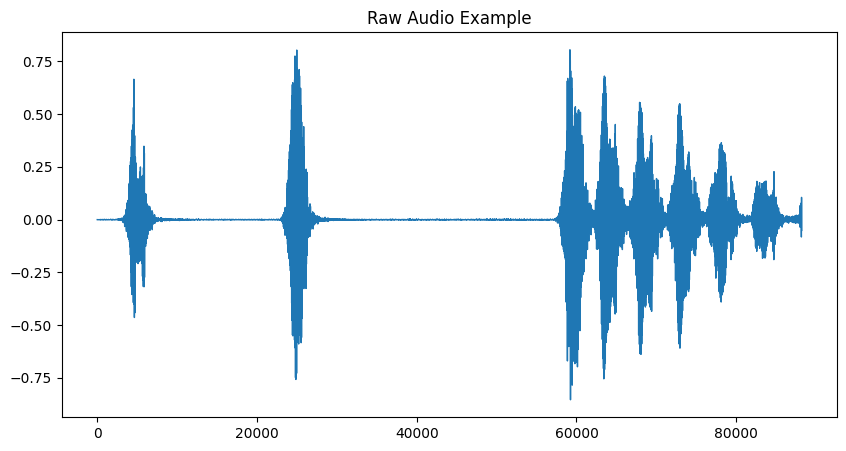

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 )
plt.show()

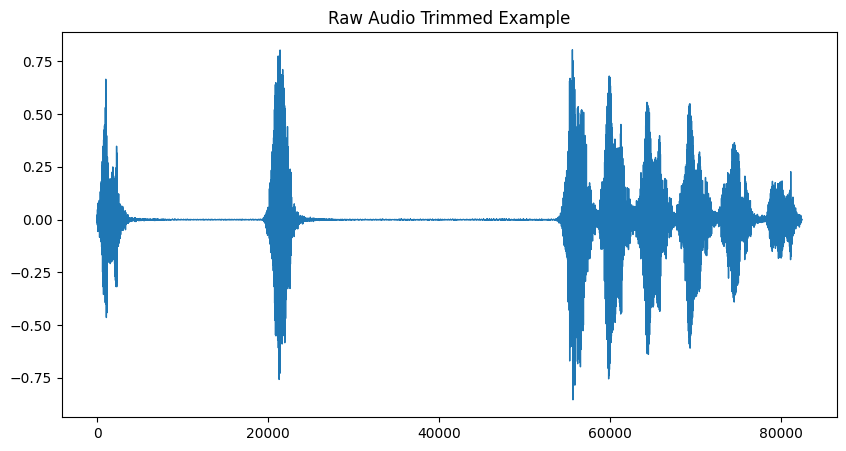

In [ ]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                )
plt.show()

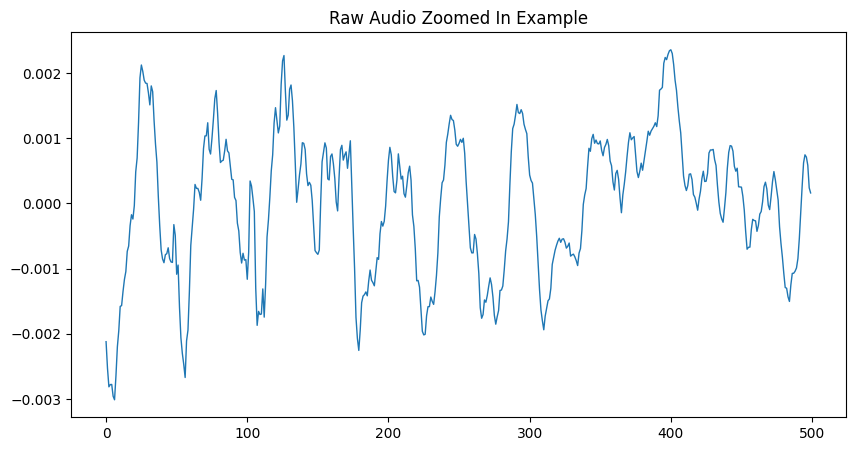

In [ ]:
pd.Series(y[30000:30500]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 )
plt.show()

# Spectogram

In [ ]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 173)

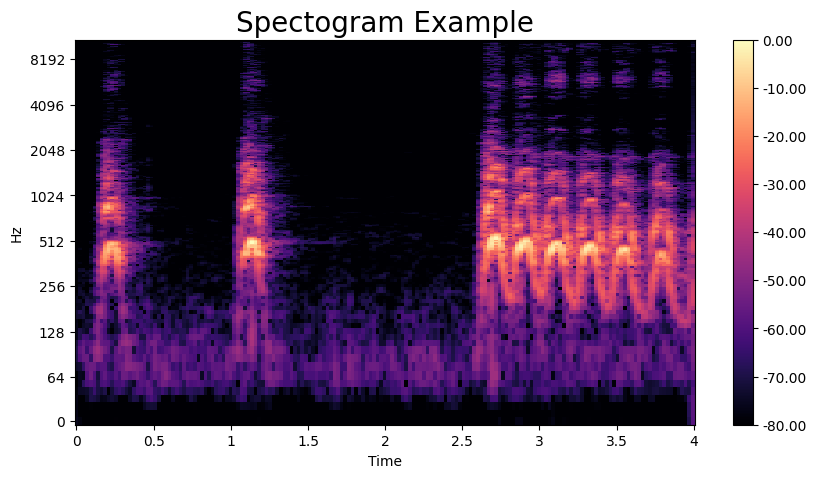

In [ ]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Mel Spectogram

In [ ]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=512,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

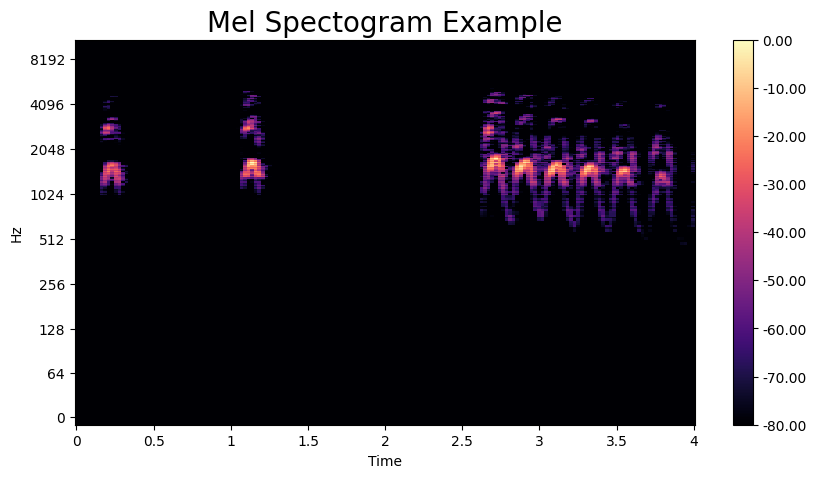

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Data preparation

This code processes audio data from the UrbanSound8K dataset to prepare features and labels for a machine learning model. The key steps include:

1. Feature Extraction:

    Each WAV file is converted into a log Mel spectrogram using librosa, representing its frequency content.
    Audio is standardized to 4 seconds by either truncating longer files or padding shorter ones by repeating the signal.

2. Label Processing:

    Labels are extracted from the filenames and converted into integers.
    Labels are then one-hot encoded for compatibility with classification models.

3. Data Saving:

    Features and one-hot encoded labels are saved as .npy files for efficient loading and use in subsequent steps.

4. Structure:

    The process is applied to each fold of the UrbanSound8K dataset, and results are saved in a specified output directory.
    This ensures the audio data is preprocessed and organized for easy integration into deep learning pipelines.

In [ ]:
import glob
import os
import librosa
import numpy as np
from librosa.feature import melspectrogram

def LOG_MEL_SPEC(parent_dir, sub_dir):
    labels = []
    log_mel_spectrogram = []
    exten = "*.wav"
    
    for filename in glob.glob(os.path.join(parent_dir, sub_dir, exten)):
        # Extract label from filename - assuming the class name is embedded in the filename
        label = filename.split('fold')[1].split('-')[1]  # Adjust this as necessary for the filename format
        labels.append(int(label))  # Convert label to integer
        f, sr = librosa.load(filename, sr=16000)  # Load audio file with 16kHz sample rate
        
        # Define target duration (4 seconds)
        four_sec_samples = 4 * sr
        if len(f) >= four_sec_samples:
            # Take first 4 seconds if the audio is long enough
            log_mel_spec = librosa.power_to_db(
                melspectrogram(y=f[:four_sec_samples], sr=sr, n_fft=1024, hop_length=128)
            )
        else:
            # Pad audio to 4 seconds if it's shorter
            while len(f) < four_sec_samples:
                f = np.concatenate((f, f))  # Repeat audio to pad
            log_mel_spec = librosa.power_to_db(
                melspectrogram(y=f[:four_sec_samples], sr=sr, n_fft=1024, hop_length=128)
            )
        
        log_mel_spectrogram.append(log_mel_spec)
    
    return np.array(log_mel_spectrogram), np.array(labels, dtype=int)

def encode(labels):
    # One hot encoding of labels
    labels_total = len(labels)
    unique_labels_total = len(np.unique(labels))
    one_hot_encoded = np.zeros((labels_total, unique_labels_total))
    one_hot_encoded[np.arange(labels_total), labels] = 1
    return one_hot_encoded

def file_creator(final_path, filename):
    new_path = os.path.join(os.getcwd(), final_path)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    return os.path.join(new_path, filename)

# Set the parent directory where UrbanSound8K data is stored
parent_directory = 'UrbanSound8K/audio'  # Adjust this path as needed
final_dir = "UrbanSound8K/UrbanSound8K_Processed"

# Process each fold and save the features and labels
sub_dirs = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']

for sub_dir in sub_dirs:
    print(f"Processing {sub_dir}...")
    features, labels = LOG_MEL_SPEC(parent_directory, sub_dir)
    
    # One hot encode the labels
    labels_encoded = encode(labels)
    
    # Create filenames for saving features and labels
    feature_file = file_creator(final_dir, f'{sub_dir}_features.npy')
    labels_file = file_creator(final_dir, f'{sub_dir}_labels.npy')
    
    # Save the extracted features and labels
    np.save(feature_file, features)
    print(f"Saved features for {sub_dir} at {feature_file}")
    np.save(labels_file, labels_encoded)
    print(f"Saved labels for {sub_dir} at {labels_file}")


Processing fold1...
Saved features for fold1 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold1_features.npy
Saved labels for fold1 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold1_labels.npy
Processing fold2...
Saved features for fold2 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold2_features.npy
Saved labels for fold2 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold2_labels.npy
Processing fold3...
Saved features for fold3 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold3_features.npy
Saved labels for fold3 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold3_labels.npy
Processing fold4...
Saved features for fold4 at c:\Users\j

1. Fold Assignment and Data Preparation
Assigns specific folds for training, validation, and testing, ensuring proper data splits. Also loads preprocessed features and labels.

In [4]:
# Load the features and labels for each fold
processed_dir = 'UrbanSound8K/UrbanSound8K_Processed'

# Specify folds
folds = [f'fold{i}' for i in range(1, 11)]  # Folds 1 to 10

# Assign test, validation, and training folds dynamically
test_fold = folds[9]  # Use fold 8 for testing (index 7)
validation_fold = folds[8]  # Use fold 9 for validation (index 8)
train_folds = [fold for fold in folds if fold not in [test_fold, validation_fold]]  # Remaining for training

# Debugging: Print the fold assignments
print(f"Training folds: {train_folds}")
print(f"Validation fold: {validation_fold}")
print(f"Test fold: {test_fold}")

Training folds: ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8']
Validation fold: fold9
Test fold: fold10


2. Data Loading Function
Defines a function to load features and labels for specified folds and concatenates them.

In [5]:
def load_data(folds, processed_dir):
    features_list, labels_list = [], []
    for fold in folds:
        features_file = f"{processed_dir}/{fold}_features.npy"
        labels_file = f"{processed_dir}/{fold}_labels.npy"
        features_list.append(np.load(features_file))
        labels_list.append(np.load(labels_file))
    return np.concatenate(features_list), np.concatenate(labels_list)
# Load training, validation, and test data
X_train, y_train = load_data(train_folds, processed_dir)
X_val, y_val = load_data([validation_fold], processed_dir)
X_test, y_test = load_data([test_fold], processed_dir)

# Reshape features for CNN input: (samples, height, width, channels)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Ensure labels are one-hot encoded
num_classes = 10
y_train = np.reshape(y_train, (-1, num_classes))
y_val = np.reshape(y_val, (-1, num_classes))
y_test = np.reshape(y_test, (-1, num_classes))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (7079, 128, 501, 1), y_train shape: (7079, 10)
X_val shape: (816, 128, 501, 1), y_val shape: (816, 10)
X_test shape: (837, 128, 501, 1), y_test shape: (837, 10)


## 3. CNN Model Architecture

### 1. Input Layer
- Shape: (128, 251, 1)
    - 128: Number of Mel frequency bins (height).
    - 251: Number of time steps derived from the audio's duration and spectrogram parameters (width).
- 1: Number of channels (grayscale spectrogram).
- Purpose: Processes spectrogram input data for subsequent convolutional layers.
### 2. First Convolutional Block
Layer: Conv2D with 32 filters, kernel size (3, 3), and activation tanh.
- Extracts low-level features such as edges or simple patterns from the spectrogram.
- Uses 'same' padding to retain the input shape.
- Pooling: MaxPooling2D with pool size (2, 2).
- Reduces the dimensions by half to decrease computational complexity.
### 3. Second Convolutional Block
Layer: Conv2D with 64 filters, kernel size (3, 3), and activation relu.
- Detects more complex features like texture or frequency patterns.
- Pooling: MaxPooling2D with pool size (2, 2).
- Further reduces dimensions, promoting feature abstraction.
### 4. Third Convolutional Block
Layer: Conv2D with 128 filters, kernel size (3, 3), and activation relu.
- Captures high-level features, enabling the model to distinguish between classes effectively.
- Pooling: MaxPooling2D with pool size (2, 2).
- Prevents feature map dimensions from collapsing while abstracting further.
### 5. Global Average Pooling Layer
Layer: GlobalAveragePooling2D.
- Replaces fully connected layers by averaging the feature map across its spatial dimensions.
- Reduces the number of parameters, minimizing overfitting risks.
- Purpose: Converts spatial features into a vector for dense layer input.
### 6. Dense Layers
First Dense Layer:
- Units: 128 neurons.
- Activation: relu for non-linear transformations.
- Captures high-level abstractions.
Second Dense Layer:
- Units: 64 neurons.
- Activation: relu.
- Refines learned abstractions from the first dense layer.
### 7. Output Layer
Layer: Fully connected Dense with 10 neurons (number of classes).
- Activation: softmax.
- Converts logits into probabilities, summing to 1, suitable for multi-class classification.
- Purpose: Outputs the predicted probabilities for each class.

In [4]:
model = models.Sequential([
    layers.InputLayer(input_shape=(128, 251, 1)),  # Input shape matches your data
    
    # Example of convolutional layers with 'same' padding
    layers.Conv2D(32, (3, 3), activation='tanh'),  # 'same' padding keeps dimensions
    layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling reduces dimensions

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling further reduces dimensions

    # Example of a smaller pool size to prevent dimension collapse
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),  # More pooling layers

    # Flatten and output layers
    layers.GlobalAveragePooling2D(),
    layers.Dense(128,activation='relu'),
    layers.Dense(10, activation='softmax')  # Adjust to match the number of classes in your dataset
])

model.summary()

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 249, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 124, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 122, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

4. Generating Noisy Examples
Generates noisy data based on misclassified validation samples to augment the training data.

In [2]:
def generate_noisy_examples(X, y, model, noise_factor=0.1, ratio=0.1):
    """
    Generate a limited number of noisy examples for misclassified samples.
    Args:
        X: Input validation data.
        y: True labels for validation data.
        model: Trained model for prediction.
        noise_factor: The magnitude of noise to add.
        ratio: Proportion of noisy samples to generate relative to misclassifications (e.g., 0.1 for 1:10).
    Returns:
        X_noisy: Generated noisy samples.
        y_noisy: Corresponding labels for noisy samples.
    """
    # Predict on the validation data
    y_pred = model.predict(X)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y, axis=1)
    
    # Identify misclassified samples
    misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]
        # Determine the number of noisy samples to generate
    num_noisy_samples = max(1, int(len(misclassified_indices) * ratio))  # At least 1 sample
    print(f"Total misclassified: {len(misclassified_indices)}, Ratio: {ratio}, Noisy samples to generate: {num_noisy_samples}")

    
    # Determine the number of noisy samples to generate
    num_noisy_samples = max(1, int(len(misclassified_indices) * ratio))  # At least 1 sample
    selected_indices = np.random.choice(misclassified_indices, size=num_noisy_samples, replace=False)
    
    X_noisy = []
    y_noisy = []
    
    for idx in selected_indices:
        # Add Gaussian noise to the misclassified sample
        noise = noise_factor * np.random.normal(size=X[idx].shape)
        noisy_sample = np.clip(X[idx] + noise, 0, 1)  # Ensure values are within range
        X_noisy.append(noisy_sample)
        y_noisy.append(y[idx])  # Use the correct label
    
    return np.array(X_noisy), np.array(y_noisy)

5. Training the Model
Trains the model with early stopping, dynamically adds noisy examples, and saves the best weights.

In [ ]:



def load_data(folds, processed_dir):
    features_list, labels_list = [], []
    for fold in folds:
        features_file = f"{processed_dir}/{fold}_features.npy"
        labels_file = f"{processed_dir}/{fold}_labels.npy"
        features_list.append(np.load(features_file))
        labels_list.append(np.load(labels_file))
    return np.concatenate(features_list), np.concatenate(labels_list)
# Load training, validation, and test data
X_train, y_train = load_data(train_folds, processed_dir)
X_val, y_val = load_data([validation_fold], processed_dir)
X_test, y_test = load_data([test_fold], processed_dir)

# Reshape features for CNN input: (samples, height, width, channels)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Ensure labels are one-hot encoded
num_classes = 10
y_train = np.reshape(y_train, (-1, num_classes))
y_val = np.reshape(y_val, (-1, num_classes))
y_test = np.reshape(y_test, (-1, num_classes))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training with noisy examples between epochs

history = []  # To store history across all epochs
max_epochs = 50
patience_limit = 6  # To check for manual early stopping (optional)

# Initialize counters and flags
early_stop_counter = 0
best_val_loss = float('inf')  # Start with a very high value

best_weights = None  # Initialize variable to store the best weights

for epoch in range(1, max_epochs + 1):
    print(f"Epoch {epoch}/{max_epochs}")

    # Train model for one epoch
    hist = model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=1,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store history
    history.append(hist.history)

    # Extract validation loss for manual early stopping check
    val_loss = hist.history.get('val_loss', [None])[-1]
    if val_loss is not None:
        print(f"Validation Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.get_weights()  # Save best weights
            early_stop_counter = 0  # Reset counter if there's improvement
        else:
            early_stop_counter += 1  # Increment counter if no improvement

    # Check for early stopping (manual or callback-based)
    if early_stop_counter >= patience_limit:
        print(f"Early stopping triggered after {epoch} epochs. Best val_loss: {best_val_loss:.4f}")
        model.set_weights(best_weights)  # Restore the best weights
        break

    # Generate noisy examples based on validation performance
    X_noisy, y_noisy = generate_noisy_examples(X_val, y_val, model, noise_factor=0.05, ratio=0.1)

    # Inject noisy examples back into training
    if len(X_noisy) > 0:
        X_train = np.concatenate([X_train, X_noisy])
        y_train = np.concatenate([y_train, y_noisy])
        print(f"Added {len(X_noisy)} noisy examples to the training set.")





MemoryError: Unable to allocate 214. MiB for an array with shape (55983744,) and data type float32

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1, Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 112s 974ms/step - accuracy: 0.1982 - loss: 2.1133 - val_accuracy: 0.3333 - val_loss: 1.7563 - learning_rate: 0.0010
Validation Loss: 1.7563
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step
Total misclassified: 592, Ratio: 0.1, Noisy samples to generate: 59
Added 59 noisy examples to the training set.
Fold 1, Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.4121 - loss: 1.5754 - val_accuracy: 0.3829 - val_loss: 1.5070 - learning_rate: 0.0010
Validation Loss: 1.5070
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step
Total misclassified: 548, Ratio: 0.1, Noisy samples to generate: 54
Added 54 noisy examples to the training set.
Fold 1, Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5097 - loss: 1.3285 - val_accuracy: 0.5282 - val_loss: 1.2529 - learning_rate: 0.0010
Validation Loss: 1.2529
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step
Total misclassified: 419, Ratio: 0.1, Noisy samples to generate: 41
Added 41 noisy examples t

Validation Loss: 0.8726
Early stopping triggered after 21 epochs. Best val_loss: 0.8449
Fold 1 Test Accuracy: 0.70
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step


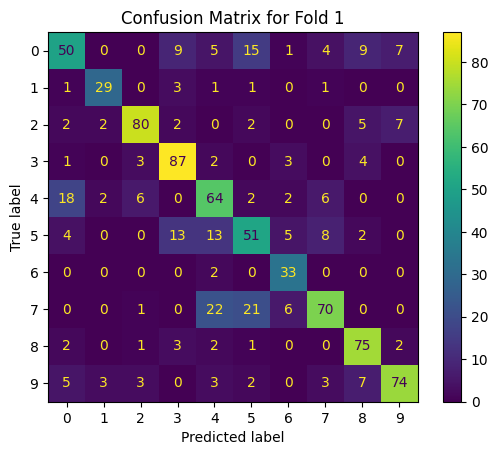

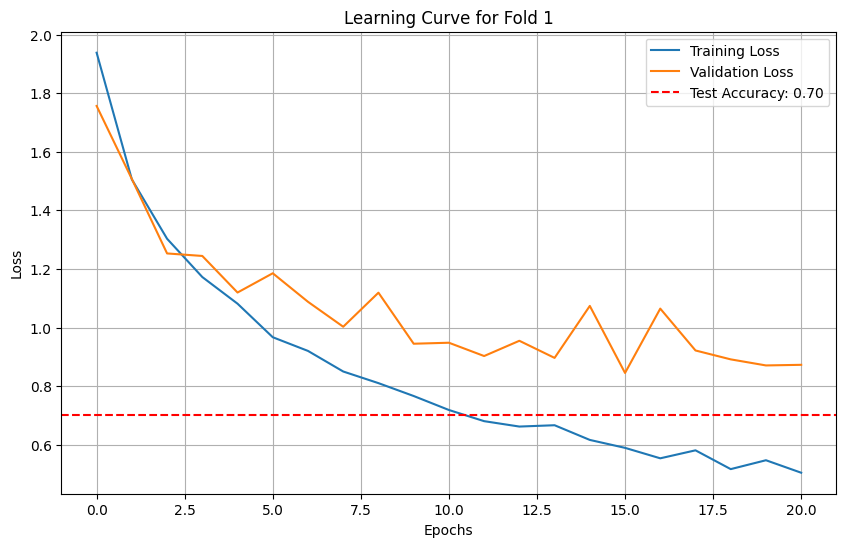

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2, Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.2114 - loss: 2.0782 - val_accuracy: 0.3859 - val_loss: 1.8288 - learning_rate: 0.0010
Validation Loss: 1.8288
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step
Total misclassified: 568, Ratio: 0.1, Noisy samples to generate: 56
Added 56 noisy examples to the training set.
Fold 2, Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 98s 882ms/step - accuracy: 0.4545 - loss: 1.5255 - val_accuracy: 0.3654 - val_loss: 1.6878 - learning_rate: 0.0010
Validation Loss: 1.6878
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step
Total misclassified: 587, Ratio: 0.1, Noisy samples to generate: 58
Added 58 noisy examples to the training set.
Fold 2, Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 115s 996ms/step - accuracy: 0.5511 - loss: 1.2824 - val_accuracy: 0.4746 - val_loss: 1.4921 - learning_rate: 0.0010
Validation Loss: 1.4921
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step
Total misclassified: 486, Ratio: 0.1, Noisy samples to generate: 48
Added 48 noisy examples

Validation Loss: 1.4449
Early stopping triggered after 16 epochs. Best val_loss: 1.2043
Fold 2 Test Accuracy: 0.66
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step


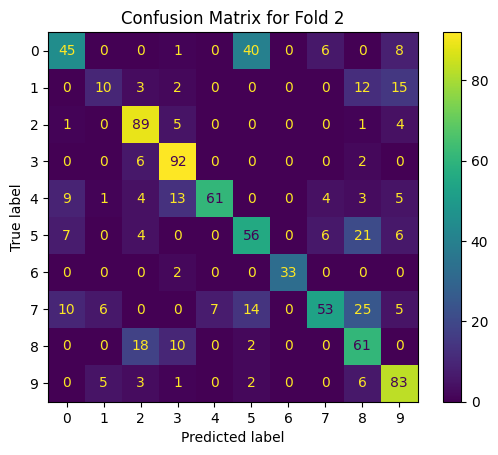

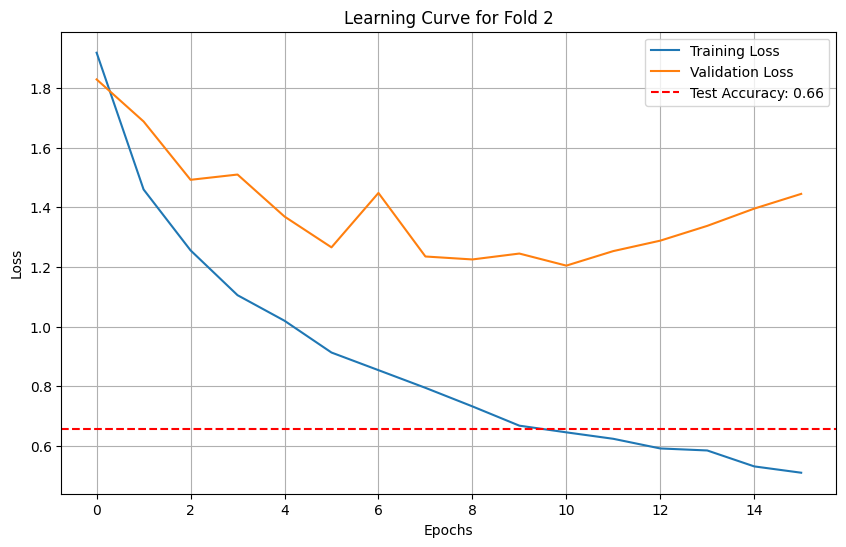

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3, Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2322 - loss: 2.0689 - val_accuracy: 0.4364 - val_loss: 1.6520 - learning_rate: 0.0010
Validation Loss: 1.6520
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step
Total misclassified: 558, Ratio: 0.1, Noisy samples to generate: 55
Added 55 noisy examples to the training set.
Fold 3, Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 111s 978ms/step - accuracy: 0.4698 - loss: 1.4616 - val_accuracy: 0.5192 - val_loss: 1.4546 - learning_rate: 0.0010
Validation Loss: 1.4546
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step
Total misclassified: 476, Ratio: 0.1, Noisy samples to generate: 47
Added 47 noisy examples to the training set.
Fold 3, Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 111s 934ms/step - accuracy: 0.5692 - loss: 1.2186 - val_accuracy: 0.5293 - val_loss: 1.3373 - learning_rate: 0.0010
Validation Loss: 1.3373
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step
Total misclassified: 466, Ratio: 0.1, Noisy samples to generate: 46
Added 46 noisy example

MemoryError: Unable to allocate 1.74 GiB for an array with shape (7291, 128, 501, 1) and data type float32

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Directories
processed_dir = 'UrbanSound8K/UrbanSound8K_Processed'

# Define folds
folds = [f'fold{i}' for i in range(1, 11)]
num_classes = 10

def load_data(folds, processed_dir):
    features_list, labels_list = [], []
    for fold in folds:
        features_file = f"{processed_dir}/{fold}_features.npy"
        labels_file = f"{processed_dir}/{fold}_labels.npy"
        features_list.append(np.load(features_file))
        labels_list.append(np.load(labels_file))
    return np.concatenate(features_list), np.concatenate(labels_list)

def plot_learning_curve(history, test_accuracy, fold_idx):
    """Plot learning curve."""
    train_loss = [h['loss'] for h in history]
    val_loss = [h['val_loss'] for h in history]

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f"Test Accuracy: {test_accuracy:.2f}")
    plt.title(f"Learning Curve for Fold {fold_idx + 1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Generate model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='tanh', input_shape=(128, 251, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation
# Cross-validation with noisy examples between epochs
for fold_idx, test_fold in enumerate(folds):
    validation_fold = folds[(fold_idx + 1) % 10]  # Use the next fold as validation
    train_folds = [f for f in folds if f not in [test_fold, validation_fold]]

    # Load data
    X_train, y_train = load_data(train_folds, processed_dir)
    X_val, y_val = load_data([validation_fold], processed_dir)
    X_test, y_test = load_data([test_fold], processed_dir)

    # Reshape for CNN
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    y_train = np.reshape(y_train, (-1, num_classes))
    y_val = np.reshape(y_val, (-1, num_classes))
    y_test = np.reshape(y_test, (-1, num_classes))

    # Create and compile model
    model = create_model()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Training with noisy examples
    max_epochs = 50
    patience_limit = 5
    early_stop_counter = 0
    best_val_loss = float('inf')
    best_weights = None
    history = []

    for epoch in range(1, max_epochs + 1):
        print(f"Fold {fold_idx + 1}, Epoch {epoch}/{max_epochs}")

        # Train model for one epoch
        hist = model.fit(
            X_train,
            y_train,
            batch_size=64,
            epochs=1,
            validation_data=(X_val, y_val),
            verbose=1,
            callbacks=[early_stopping, reduce_lr]
        )

        # Store history
        history.append(hist.history)

        # Extract validation loss
        val_loss = hist.history.get('val_loss', [None])[-1]
        if val_loss is not None:
            print(f"Validation Loss: {val_loss:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = model.get_weights()  # Save best weights
                early_stop_counter = 0
            else:
                early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience_limit:
            print(f"Early stopping triggered after {epoch} epochs. Best val_loss: {best_val_loss:.4f}")
            model.set_weights(best_weights)  # Restore best weights
            break

        # Generate noisy examples and augment training data
        X_noisy, y_noisy = generate_noisy_examples(X_val, y_val, model, noise_factor=0.05, ratio=0.1)
        if len(X_noisy) > 0:
            X_train = np.concatenate([X_train, X_noisy])
            y_train = np.concatenate([y_train, y_noisy])
            print(f"Added {len(X_noisy)} noisy examples to the training set.")

    # Save the model
    model.save(f"model_fold_{fold_idx + 1}.h5")

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold_idx + 1} Test Accuracy: {test_accuracy:.2f}")

    # Compute confusion matrix
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for Fold {fold_idx + 1}")
    plt.show()

    # Plot learning curve
    plot_learning_curve(history, test_accuracy, fold_idx)


6. Model Evaluation
Evaluates the model on the test dataset.

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
